## plots for Exoplanets II poster

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.dpi"] = 150.0
fs = 18 # font size

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [4]:
np.random.seed(42)
fwhms = np.asarray([0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879]) # FWHM of Gaussian fit to line (A)
sigs = fwhms / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = np.asarray([4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87]) # line center (A)
cs = np.asarray([-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536]) # contrast (normalized flux)
ds = np.log(1. + cs) * sigs * sqrttwopi # trust us
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
snr = 100.
N = 64
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs, snr)

In [5]:
crlb = calc_crlb(xs, ds, ms, sigs, N, ivars)
print("CRLB: {0:.2f} m/s".format(crlb))

CRLB: 11.07 m/s


In [6]:
template_xs, template_ys = make_template(data, true_rvs, xs, dx, plot=False)

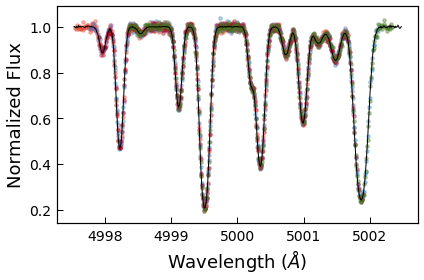

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
for n in range(5):
    ax.scatter(xs * doppler(true_rvs[n]), data[n], marker=".", alpha=0.4)
ax.plot(template_xs, template_ys, color='black', lw=1)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=fs)
ax.set_ylabel(r'Normalized Flux', fontsize=fs)
fig.tight_layout()
plt.savefig('poster_template.png')

In [9]:
guess_rvs = true_rvs + np.random.normal(0., 100., size=N) # add in some random dispersion
rvs_0 = guess_rvs
template_xs, template_ys = make_template(data, guess_rvs, xs, dx, plot=False)
args = (xs, template_xs, template_ys)
for n in range(N):
    rvs, objs = get_objective_on_grid(data[n], ivars[n], shift_template, args, rvs_0[n], 1024.)
    rv = quadratic_max(rvs, objs)  # update best guess
    if np.isfinite(rv):
        rvs_0[n] = rv

In [10]:
rms = np.sqrt(np.nanvar(rvs_0 - true_rvs, ddof=1)) # m/s    
print("Binary mask x-correlation: RV RMS = {0:.2f} m/s".format(rms))

Binary mask x-correlation: RV RMS = 11.26 m/s


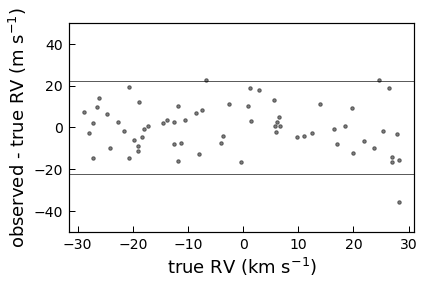

In [12]:
resid = rvs_0 - true_rvs
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(true_rvs * 1.e-3, resid - np.median(resid), "k.", alpha=0.5)
ax.axhline(2. * crlb, color="k", lw=0.8, alpha=0.8)
ax.axhline(-2. * crlb, color="k", lw=0.8, alpha=0.8)
ax.set_xlabel(r"true RV (km s$^{-1}$)", fontsize=fs)
ax.set_ylabel(r"observed - true RV (m s$^{-1}$)", fontsize=fs)
ax.set_ylim(-50., 50.)
fig.tight_layout()
plt.savefig('poster_crlb.png')